In [ ]:
# Recommender Systems in Python 101
# https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101
# tutorial on Recommender Systems
# specifically how to implement Collaborative Filtering, Content Based Filtering and Hybrid Methods
# in Python for the task of providing personalized recommendations to the user

In [24]:
import pandas as pd
import os
import math
from sklearn.model_selection import train_test_split
import logging
import random
import nltk
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats 

In [4]:
def get_data():
    # shared acticles
    # df contains info of shared articles on the platform
    path = '/Users/pliu/Downloads/articles/'
    articles_df = pd.read_csv(path+'shared_articles.csv')
    articles_df = articles_df[articles_df.eventType=='CONTENT SHARED']
    
    # user interactions
    # df contains log of user interactions on the article
    # join with articles on contentId
    # eventType: view, like, comment, follow, bookmark
    interactions_df = pd.read_csv(path+'users_interactions.csv')
    
    return articles_df, interactions_df
    

In [5]:
articles_df, interactions_df = get_data()
articles_df.shape, interactions_df.shape

((3047, 13), (72312, 8))

In [4]:
interactions_df.groupby(['eventType']).size().sort_values(ascending=False)

eventType
VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
dtype: int64

In [6]:
# encoding the engagement level of user event type
event_type_strength = {
    'VIEW':1.0,
    'LIKE':2.0,
    'BOOKMARK':2.5,
    'COMMENT CREATED':3.0,
    'FOLLOW':4.0
}
interactions_df['eventStrength'] = interactions_df['eventType'].map(event_type_strength)
interactions_df.groupby(['eventStrength']).size().sort_values(ascending=False)

eventStrength
1.0    61086
2.0     5745
2.5     2463
3.0     1611
4.0     1407
dtype: int64

In [7]:
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,4.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


In [9]:
person_actions_count = interactions_df.groupby(['personId', 'contentId']).size() \
                                      .groupby('personId').size()
                                      
len(person_actions_count) # num of unique                                   

1895

In [14]:
inter_user_item.index.name

'personId'

In [11]:
inter_user_item_filter = person_actions_count[person_actions_count>=5].reset_index()[['personId']]
#inter_user_item_filter
print(len(inter_user_item_filter))
inter_user_item_filter.head() # count_of_content_per_user

1140


,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884
3,-9199575329909162940
4,-9196668942822132778


In [12]:
print(f'num of original interactions data {len(interactions_df)}')

interactions_df_filtered = interactions_df.merge(inter_user_item_filter,
                                                 how='right',
                                                 left_on='personId',
                                                 right_on='personId')
print(f'num of filtered interactions data {len(interactions_df_filtered)}')

# interactions_df_selected

num of original interactions data 72312
num of filtered interactions data 69868


In [32]:
# calculate a user's interest on an item
# measured by accumulated eventStrength
interactions_full_df = interactions_df_filtered.groupby(['personId', 'contentId']) \
                                                       ['eventStrength'].sum() \
                                                       .apply(lambda x: math.log(1+x,2)).reset_index() 
print(len(interactions_full_df), 'num of user - item interaction pair')
interactions_full_df.head()
# interactions_user_item_score

39106 num of user - item interaction pair


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


In [31]:
del interactions_user_item_score

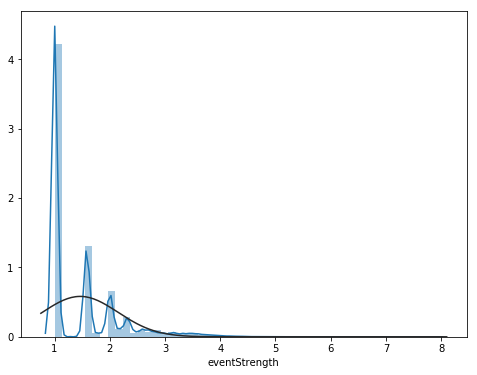

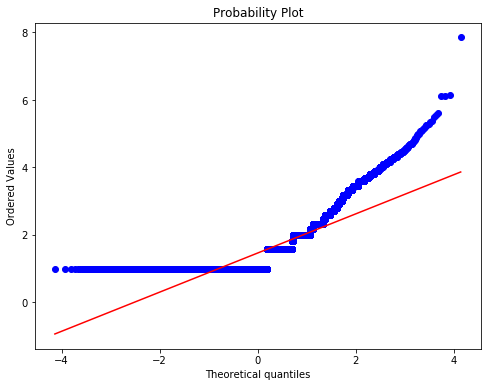

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(interactions_full_df.eventStrength, fit=norm);
fig = plt.figure(figsize=(8,6))
res = stats.probplot(interactions_full_df.eventStrength, plot=plt)
plt.show();

## Evaluation

In [34]:
# split training and test datasets

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                                               stratify=interactions_full_df['personId'],
                                                               test_size=0.2,
                                                               random_state=42)
interactions_train_df.shape, interactions_test_df.shape

((31284, 3), (7822, 3))

In [35]:
# indexing to acclerate modelling
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [ ]:
# evaliation metrics
# Top-N
# evaluate accuracy of recommended items compared to the really interacted items
# accuray is Recalll@N, which is the interacted items (ground truth) are in the Top N (predictions)

In [36]:
SAMPLE_SIZE = 100

class ModelEvaluator:
    
    def get_items_interacted(self, person_id, df):
        # get list of item_id that were interacted with person_id
        item_id = df.loc[person_id]['contentId']
        return set(item_id if type(item_id)==pd.Series else [item_id])
    
    
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        
        # get interacted items id
        interacted_items = self.get_items_interacted(person_id, interactions_full_indexed_df)
        
        # get all items id
        all_items = set(articles_df['contentId'])
        
        # get not interacted items id
        not_interacted_items = all_items - interacted_items
        
        # take a sample of not-interacted items
        random.seed(seed)
        not_interacted_items_sample = random.sample(not_interacted_items, sample_size)
        
        return set(not_interacted_items_sample)
    
    
    def get_model_recommend(self, model, person_id):
        
        # interacted_items are items to be ingored
        items_to_ignore = self.get_items_interacted(person_id, interactions_full_indexed_df)
        
        # recommended items
        rec = model.recommend_items(person_id, items_to_ignore, 10000000000)
    
        # return recommended items
        return rec
    
    
    
    def evaluate_model_for_user(self, model, person_id):
        # get iteracted items id in test dataset
        item_id = interactions_test_indexed_df.loc[person_id]['contentId']
        
        item_id_set = set(item_id if type(item_id)==pd.Series else [int(item_id)])
        
        item_id_set_count = len(item_id_set)
        
        # get recommended items
        rec = self.get_model_recommend(self, model, person_id)
              
        # start to evaluate how many top_5 and top_10 recommend items in test (ground truth)
        hits_top_5 = hits_top_10 = 0
        
        # iterate over the interacted items in test dataset (ground truth)
        for item in item_id_set:
            # get sample of not interacted items
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, SAMPLE_SIZE)
            
            # combine currently-interacted and randmomly sampled nont-interected items
            items_to_filter_rec = non_interacted_items_sample.union(set(item))
            
            # filter
            valid_rec_df = rec[rec['contentId'].isin(items_to_filter_rec)]
            
            # get recommended items
            valid_recs = valid_rec_df['contentId'].values
            
    
    
    
    
    
    
        
        

In [98]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    
    def get_items_interacted(self, personId, interactions_df):
        """get user's info and items he interacted with
        input: personId: int, interactions_df: pandas.DF
        return: set of list of iteracted items of personId
        """
        items = interactions_df.loc[personId]['contentId']
        return set(items if type(items)==pd.Series else [items])


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        """get sample of items that a user has not interacted with yet
        input: personId: int, sample_size: float
        return: set of list of not-iteracted items of personId
        """        
        logging.warning('get not interacted items sample')        
        
        # get user's info and items he interacted with
        interacted_items = self.get_items_interacted(person_id, interactions_user_item_score)
        
        # get all items
        all_items = set(articles_df['contentId'])
        
        # get items that he not interacted
        non_interacted_items = all_items - interacted_items
        
        # get sample of not interacted items
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        
        return set(non_interacted_items_sample)

 
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        """get sevaluation
        input: personId: int, sample_size: float
        return: set of list of not-iteracted items of personId
        """  
        logging.warning('evaluate model for a specific user')        

        # build ground truth - interacted items of a user in the test dataset
        #Getting the items in test set
        interacted_values_testset = interactions_test.loc[person_id]
       
        # if there are mutiple items, get the set of itmes ID
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])

        # if there is only single item, form a list and get the set
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  

        # count of ground truth
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # build predictions
        #Getting a ranked recommendation list from a model for a given user
        items_in_train = self.get_items_interacted(person_id,interactions_train)
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=items_in_train, 
                                               top_n=10000000000)

        # evaluate predictions based on groud truth
        hits_at_5_count = hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are 
            # either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
           
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        # return res
        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics


    def evaluate_model(self, model):
        logging.warning('evaluate model overall performance')        

        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df

In [99]:
model_evaluator = ModelEvaluator()

In [38]:
# Baseline model
# Popularity model
# not personalized rather account for 'wisdom of the crowds'
# recommends to the user the most popular items that have not been consumed by the user

# compute popular items
popular_table = interactions_full_df.groupby(['contentId'])['eventStrength'].sum() \
                                    .sort_values(ascending=False).reset_index()
popular_table.head()

,contentId,eventStrength
0,-4029704725707465084,308.019553
1,-6783772548752091658,233.858081
2,-133139342397538859,228.024567
3,-8208801367848627943,197.253711
4,-6843047699859121724,193.825208


In [41]:
class PopularityRecommender:
    MODEL_NAME = 'Popularity'
    
    # constructor: to init this class, a popularity dataframe is required
    def __init__(self, popularity_df, item_df=None):
        self.popularity_df = popularity_df
        self.item_df = item_df
    
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], top_n=10):
        # recommend the most popular items that the user has not seen yet
        
        # filter seen data
        filter_cond = self.popularity_df['contentId'].isin(items_to_ignore)
        rec_df = self.popularity_df[~filter_cond] \
                .sort_values('eventStrength', ascending=False) \
                .head(top_n)
        
        return rec_df

# init popular_table
popular_model = PopularityRecommender(popular_table)

In [96]:
class PupularityRecommender:
    
    MODEL_NAME = 'Pupularity'
    
    def __init__(self, item_popularity, items=None):
        self.item_popularity = item_popularity
        self.items = items
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, top_n=10, verbose=False, items_to_ignore=[]):
        # recommend the most popular items that the user has not seen yet
        to_be_ignored = self.item_popularity['contentId'].isin(items_to_ignore)
        recommended = self.item_popularity[~to_be_ignored] \
            .sort_values('eventStrength', ascending=False) \
            .head(top_n)
        
        # return a data frame merged with items details
        # otherwise return a df with only 2 cols: contentId and eventStrength
        if verbose:
            if self.items is None:
                raise Exception('verbose requires "items"')
            
            cols_to_add = ['eventStrength', 'contentId', 'title', 'url', 'lang']
            recommended = recommended.merge(self.items, 
                                            how='left',
                                            left_on='contentId',
                                            right_on='contentId')[cols_to_add]
            
        return recommended

In [102]:
# evaluate PupularityRecommender

popularity_model = PupularityRecommender(item_popularity, articles_df)

print('evaluate performance of PupularityRecommender')

pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

evaluate performance of PupularityRecommender


1139 users processed
global metrics: {'modelName': 'Pupularity', 'recall@5': 0.2420097161851189, 'recall@10': 0.37279468166709284}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,49,27,192,0.26,0.14
17,-2626634673110551643,25,12,134,0.19,0.09
16,-1032019229384696495,23,13,130,0.18,0.10
10,-1443636648652872475,9,5,117,0.08,0.04
82,-2979881261169775358,40,25,88,0.45,0.28


In [103]:
print('global metrics:', pop_global_metrics)

pop_detailed_results_df.head()

global metrics: {'modelName': 'Pupularity', 'recall@5': 0.2420097161851189, 'recall@10': 0.37279468166709284}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,49,27,192,0.26,0.14
17,-2626634673110551643,25,12,134,0.19,0.09
16,-1032019229384696495,23,13,130,0.18,0.10
10,-1443636648652872475,9,5,117,0.08,0.04
82,-2979881261169775358,40,25,88,0.45,0.28


In [113]:
# Content-Based Filtering Model 
# content based filtering model leverages description or attributes
# from items the user has interacted to recommend similar items
# only depends on users' previous choices

# build item profile and user profile by raw text
# TF-IDF = Term Frequency * Inverse Document Frequency
# a score to measure importance of a term in a doc
# converts unstructured text into a vector structure, 
# where each word is represented by a position in the vector,
# and the value measures how relevant a given word is for an article.

# As all items will be represented in the same Vector Space Model, 
# it is to compute similarity between articles.

stopwords_list = stopwords.words('english') + stopwords.words('portuguese')
len(stopwords_list)

# train TF_IDF model
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), 
                             min_df=0.003, max_df=0.5, max_features=5000, 
                             stop_words=stopwords_list)

# list of item id
item_ids = articles_df['contentId'].tolist()
titles_and_text = articles_df['title'] + "" + articles_df['text']

# build item profile (tfidf_matrix)
tfidf_matrix = vectorizer.fit_transform(titles_and_text)
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [ ]:
# build user profile from item profile
# take all the item profiles the user has interacted and take the average
# the average is weighted by strength

# get item profile from tfidf_matrix based on item id (contentId)
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile


def get_item_profiles(ids):
    # ids: list of contentId of a user interacted
    items_profiles_list = [get_item_profile(x) for x in ids]
    items_profiles = scipy.sparse.vstack(items_profiles_list)
    return items_profiles

def build_user_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    
    # weighted average of item profile by iteractions strength
    strengths_sum = np.sum(user_item_profiles.mutiply(user_item_strengths),axis=0)
    strengths_count = np.sum(user_item_strengths)
    strengths_avg = strengths_sum / user_item_strengths
    